# Practical 8: Association & Sequential Analyses


<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/a-kanaan/dm-practicals/blob/main/practical8/prac8_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

## Association Analysis

In [3]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('GroceryStoreDataSet.csv', names = ['products'], sep = ',')
df.head()

,products
0,"MILK,BREAD,BISCUIT"
1,"BREAD,MILK,BISCUIT,CORNFLAKES"
2,"BREAD,TEA,BOURNVITA"
3,"JAM,MAGGI,BREAD,MILK"
4,"MAGGI,TEA,BISCUIT"


### Transaction Encoder

In [5]:
data = list(df["products"].apply(lambda x:x.split(",") ))
data

[['MILK', 'BREAD', 'BISCUIT'],
 ['BREAD', 'MILK', 'BISCUIT', 'CORNFLAKES'],
 ['BREAD', 'TEA', 'BOURNVITA'],
 ['JAM', 'MAGGI', 'BREAD', 'MILK'],
 ['MAGGI', 'TEA', 'BISCUIT'],
 ['BREAD', 'TEA', 'BOURNVITA'],
 ['MAGGI', 'TEA', 'CORNFLAKES'],
 ['MAGGI', 'BREAD', 'TEA', 'BISCUIT'],
 ['JAM', 'MAGGI', 'BREAD', 'TEA'],
 ['BREAD', 'MILK'],
 ['COFFEE', 'COCK', 'BISCUIT', 'CORNFLAKES'],
 ['COFFEE', 'COCK', 'BISCUIT', 'CORNFLAKES'],
 ['COFFEE', 'SUGER', 'BOURNVITA'],
 ['BREAD', 'COFFEE', 'COCK'],
 ['BREAD', 'SUGER', 'BISCUIT'],
 ['COFFEE', 'SUGER', 'CORNFLAKES'],
 ['BREAD', 'SUGER', 'BOURNVITA'],
 ['BREAD', 'COFFEE', 'SUGER'],
 ['BREAD', 'COFFEE', 'SUGER'],
 ['TEA', 'MILK', 'COFFEE', 'CORNFLAKES']]

In [6]:
from mlxtend.preprocessing import TransactionEncoder

transEnc = TransactionEncoder()
transformed_data = transEnc.fit(data).transform(data)
df = pd.DataFrame(transformed_data, columns=transEnc.columns_)
df

,BISCUIT,BOURNVITA,BREAD,COCK,COFFEE,CORNFLAKES,JAM,MAGGI,MILK,SUGER,TEA
0,True,False,True,False,False,False,False,False,True,False,False
1,True,False,True,False,False,True,False,False,True,False,False
2,False,True,True,False,False,False,False,False,False,False,True
3,False,False,True,False,False,False,True,True,True,False,False
4,True,False,False,False,False,False,False,True,False,False,True
5,False,True,True,False,False,False,False,False,False,False,True
6,False,False,False,False,False,True,False,True,False,False,True
7,True,False,True,False,False,False,False,True,False,False,True
8,False,False,True,False,False,False,True,True,False,False,True
9,False,False,True,False,False,False,False,False,True,False,False


### Apriori

In [7]:
#set a threshold value for the support value and calculate the support value.
frequent_itemsets = apriori(df, min_support = 0.2, use_colnames = True, verbose = 1)
frequent_itemsets.head(10)

Processing 42 combinations | Sampling itemset size 3


,support,itemsets
0,0.35,(BISCUIT)
1,0.20,(BOURNVITA)
2,0.65,(BREAD)
3,0.40,(COFFEE)
4,0.30,(CORNFLAKES)
5,0.25,(MAGGI)
6,0.25,(MILK)
7,0.30,(SUGER)
8,0.35,(TEA)
9,0.20,"(BREAD, BISCUIT)"


In [8]:
#Let's view our interpretation values using the Associan rule function.
#minimum confidence level of 60% => when product X is purchased, we may claim that product Y is purchased at a rate of 60% or higher.
assoc_rules = association_rules(frequent_itemsets, metric = "confidence", min_threshold = 0.6)
assoc_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(MILK),(BREAD),0.25,0.65,0.2,0.800000,1.230769,0.0375,1.75
1,(SUGER),(BREAD),0.30,0.65,0.2,0.666667,1.025641,0.0050,1.05
2,(CORNFLAKES),(COFFEE),0.30,0.40,0.2,0.666667,1.666667,0.0800,1.80
3,(SUGER),(COFFEE),0.30,0.40,0.2,0.666667,1.666667,0.0800,1.80
4,(MAGGI),(TEA),0.25,0.35,0.2,0.800000,2.285714,0.1125,3.25


<hr/>

## Sequential Analysis (Statistical Forecasting)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np

# Define the functions

def trend(time, slope=0):
    """Linear trend"""
    return slope * time

def seasonal_pattern(season_time):
    """Repeating pattern for seasonality. Using a sinusoidal pattern here."""
    return np.where(season_time < 0.4, 
                    np.cos(season_time * 2 * np.pi), 
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeating seasonal pattern"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """Random noise"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    """Visualize the time series data"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
# Test the functions with some sample data
time = np.arange(4 * 365 + 1)
slope = 0.05
period = 365
amplitude = 40
noise_level = 5

series = trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

series[:10]  # Displaying the first 10 values of the generated series

array([42.48357077, 39.35275206, 43.31473872, 47.71182193, 38.93444534,
       38.93124221, 47.98289687, 43.89712254, 37.67392616, 42.68370684])

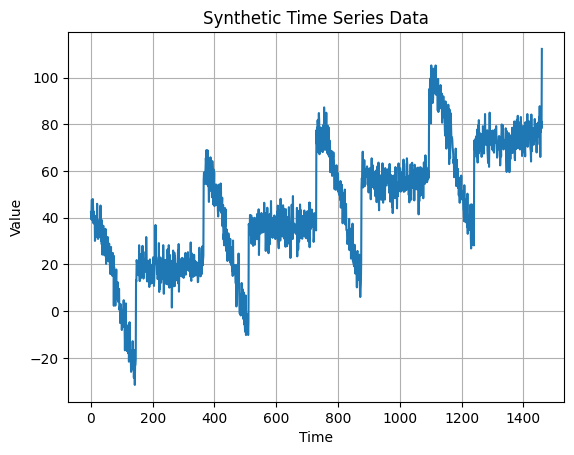

In [5]:
# Visualize the synthetic time series data using the plot_series function
plot_series(time, series)
plt.title("Synthetic Time Series Data")
plt.show()

### Split the Dataset

In [9]:
# Define the split time
split_time = 1095

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

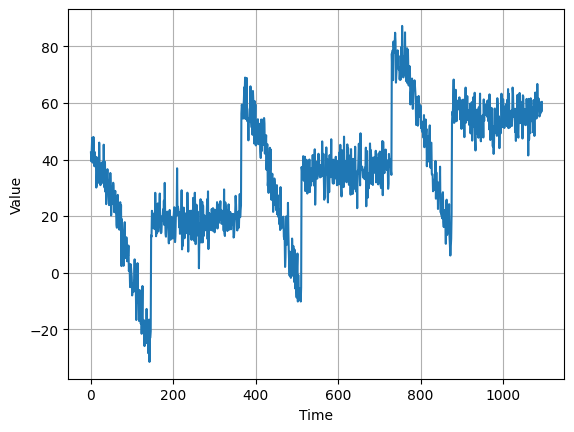

In [10]:
plot_series(time_train, x_train)

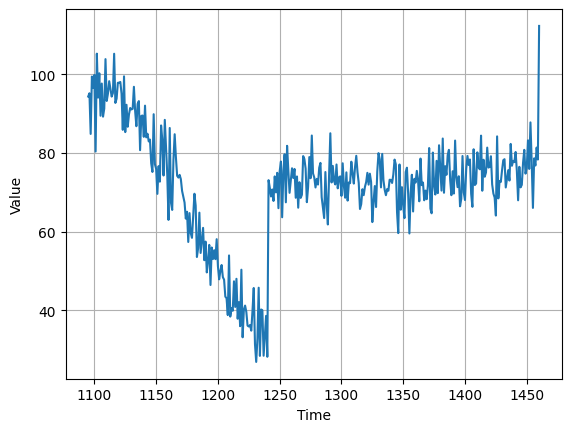

In [11]:
plot_series(time_valid, x_valid)

### Naive Forecasting

In [12]:
naive_forecast = series[split_time - 1:-1]

# Define time step
time_step = 100

# Print values
print(f'ground truth at time step {time_step}: {x_valid[time_step]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}')

ground truth at time step 100: 55.95015775601589
prediction at time step 101: 55.95015775601589


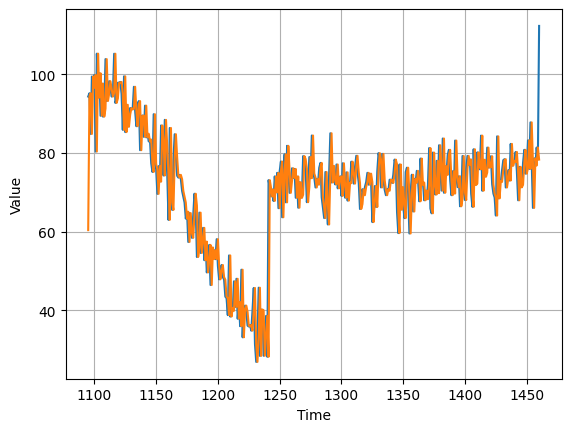

In [13]:
#plt.figure()
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

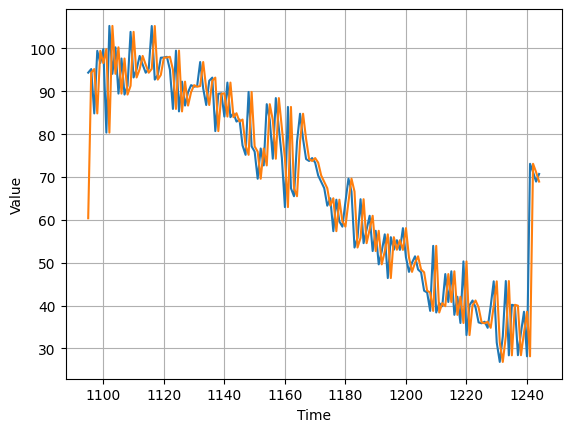

In [14]:
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=0, end=150)

### Evaluation Metrics

In [15]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

65.56230170684029
6.087921995246984


### Moving Average (Statistical Forecasting)

In [16]:
def moving_average_forecast(series, window_size):
    forecast = []
    
    for time in range(window_size, len(series)):
        #print(time - window_size, time)
        forecast.append(series[time - window_size: time].mean())
    
    forecast = np.array(forecast)
    
    return forecast

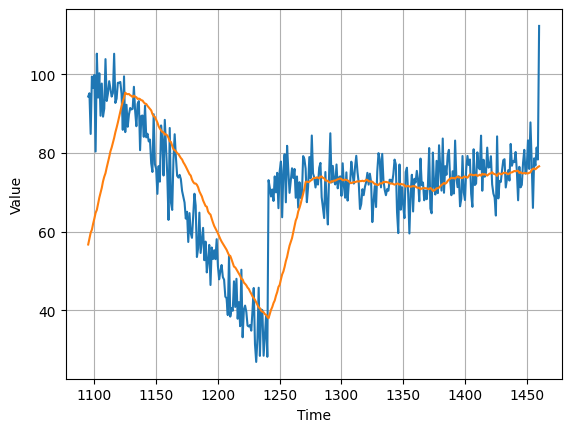

In [17]:
window_size = 30
moving_avg = moving_average_forecast(series, window_size)
moving_avg = moving_avg[split_time - window_size:]

plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [18]:
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

128.13490901137104
7.988638866306375


### Differencing

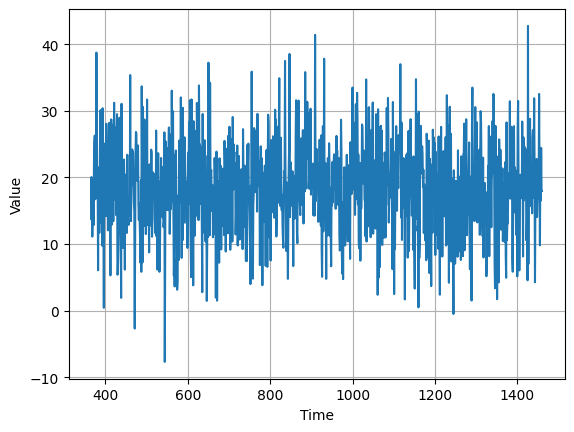

In [19]:
diff_series = (series[365:] - series[:-365])

# Truncate the first 365 time steps
diff_time = time[365:]

# Plot the results
plot_series(diff_time, diff_series)

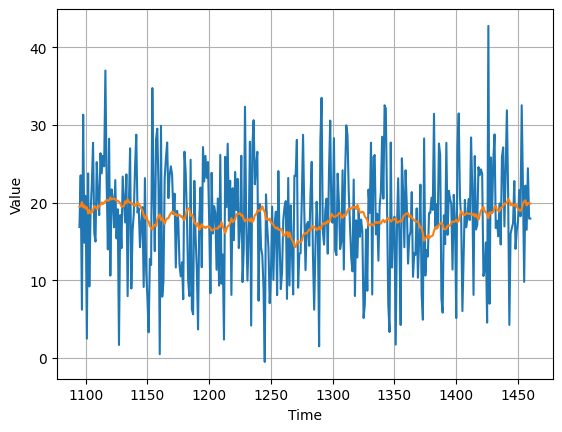

In [20]:
# Generate moving average from the time differenced dataset
diff_moving_avg = moving_average_forecast(diff_series, window_size)

# Slice the prediction points that corresponds to the validation set time steps
diff_moving_avg = diff_moving_avg[split_time - 365 - window_size:]

# Slice the ground truth points that corresponds to the validation set time steps
diff_series = diff_series[split_time - 365:]

# Plot the results
plot_series(time_valid, diff_series)
plot_series(time_valid, diff_moving_avg)

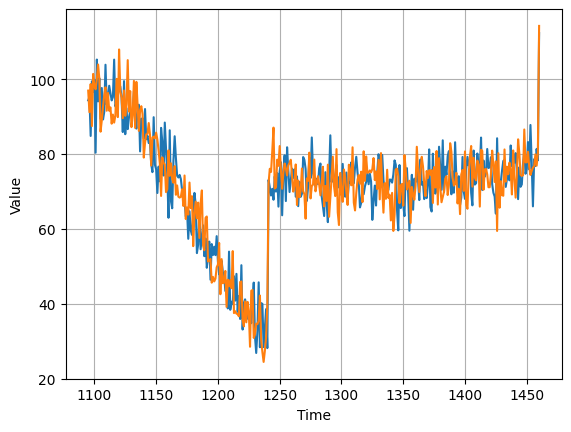

In [21]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

# Plot the results
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)

In [22]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

53.991783841010815
5.900842851492582


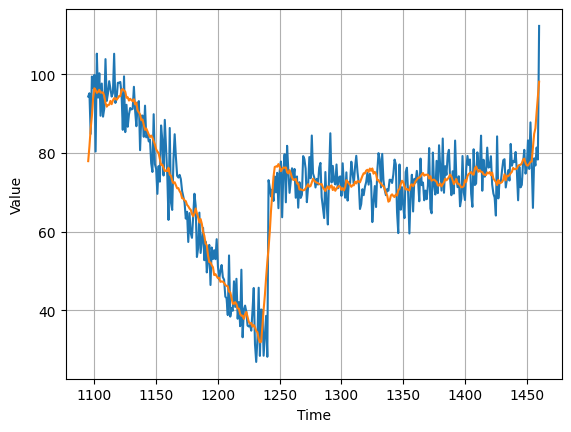

In [23]:
# Smooth the original series before adding the time differenced moving average
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg
#diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 365 - window_size:-365], window_size) + diff_moving_avg

# Plot the results
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)

In [24]:
 # Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

35.11657393198931
4.6347595004279905
